![Julia EO 2023 Banner](figures/JuliaEO_banner.png "Julia EO 2023 Banner")


In this hands-on workshop, we will introduce the [SARprocessing.jl](https://github.com/AIRCentre/SARProcessing.jl) package and see how it can be used to work with Sentinel-1 SAR images. 

This hand-on is somewhat an extention of the [Introduction of SAR, presented at JuliaEO 2023](www.link_to_pres.com). However, we assume no privious knowlegde of SAR data in this notebook.

In the privious notebook, you used the SARprocessing package to load an image. In this one we will look at the Speckle in the image.


## Table Of Contents

-  Include and Introduce SARProcessing.jl
-  Load and show Image
-  [Speckle Reduction](#speckle)
-  Object Detection in SAR images
-  Interferometry


Loading Packages

In [1]:
using SARProcessing;
using Pkg;
Pkg.add("Plots"); #not included in SARProcessing
Pkg.add("JLD")
#Pkg.add("SARProcessing"); #not included in SARProcessing
using Plots;
using Pkg;
using JLD;

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


  No Changes to `~/Documents/coding/SARProcessing.jl/Project.toml`
  No Changes to `~/Documents/coding/SARProcessing.jl/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/coding/SARProcessing.jl/Project.toml`
  No Changes to `~/Documents/coding/SARProcessing.jl/Manifest.toml`


Loading Image

In [2]:
slcSubsetPath = "../test/testData/s1a-iw3-slc-vv_subset_hight9800_10400_width11000_11000.tiff";  # a small subset of a SLC image
slc_image = abs.(SARProcessing.load_tiff(slcSubsetPath));
grd_image_hom = load("data/grd_image_hom.jld")["grd_image_hom"]; # a small subset of a homegenous area in GRD
grd_image = load("data/grd_image.jld")["grd_image"];  # a small subset of an area in GRD

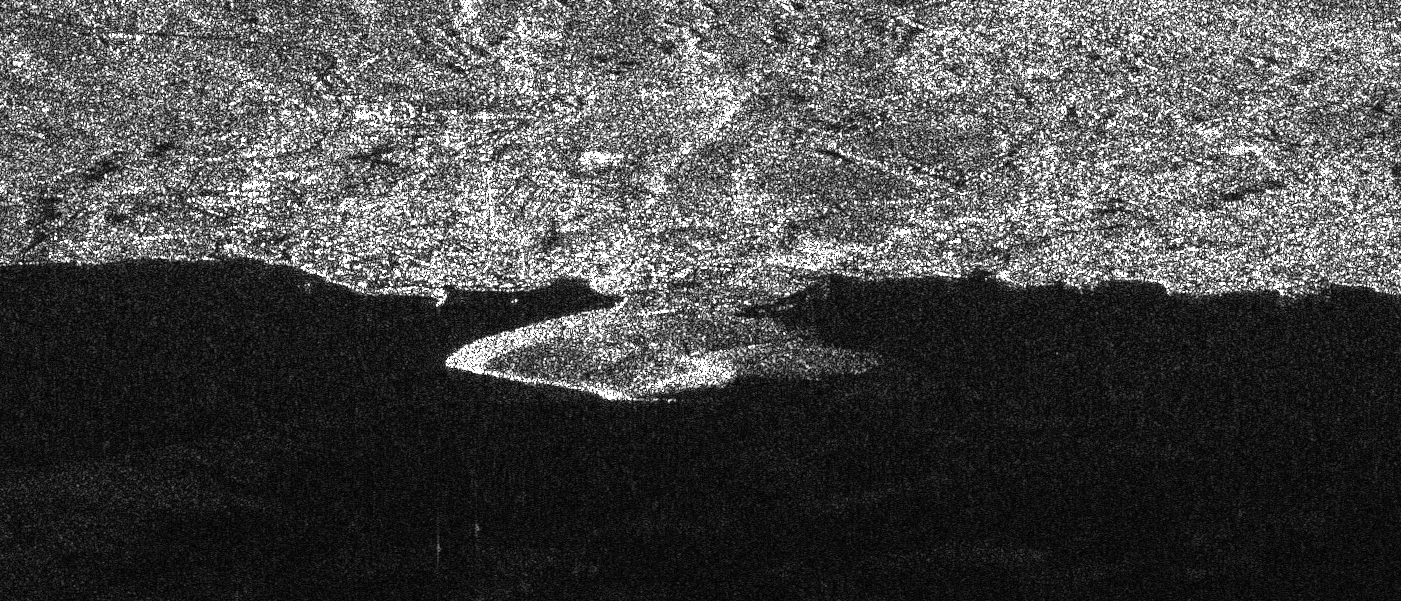

In [3]:
SARProcessing.sar2gray(slc_image, p_quantile = 0.95)

# Speckle
 <a class="anchor" id="speckle"></a>

The Sentinel-1 satellite has a spatial pixel resolution of approx 3.1 m x 21.7 m. However, in each pixel, there are very many individual scatters. Each of these individual scatters contributate with their own individual amplitude and phase

$ A exp(j \phi)  = \sum_i A_i exp(j \phi_i) $

where $A$ is the Amplitude of the signal and $\phi$ the phase.



![CFAR windows](figures/speckle.png "CFAR windows" )

The wavelength of the SAR is much smaller than the resolution cell and the distance between the individual scatters and the phase therefore varies greatly. In fact:
- The phase varies approximatly uniform in [$-\pi : \pi$]
- The phase is independant of A
- The Amplitude is uncorrelated




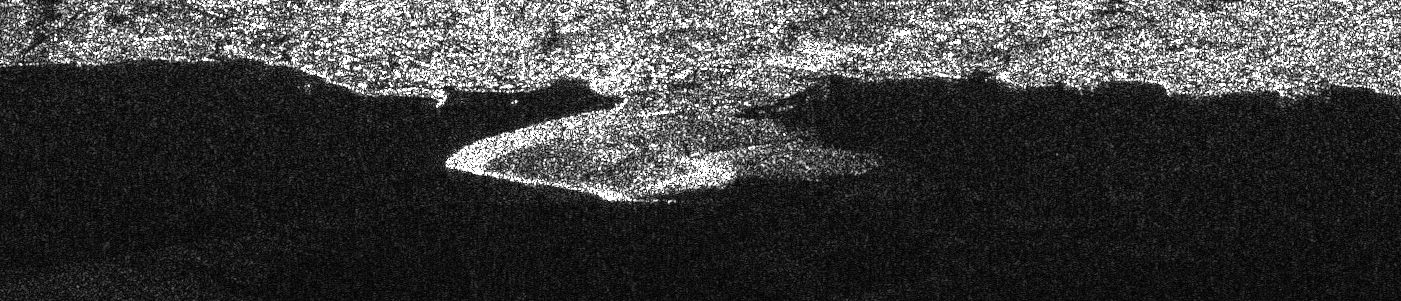

In [4]:
SARProcessing.sar2gray(slc_image[200:500,:], p_quantile = 0.95)

So even if there are homogenous areas in the ocean, it has this noise-like signature. We would like to reduce this "noise" such that we can approximate the true backscatter.

### Speckle Reduction



The objective of speckle reduction is to reduce the variance of the pixels such that a better estimate of the intensity is found. The trade-off is a poorer spatial resolution. There exsits very many speckle filters that all tries to reduce this black-white granularity. The following introduces:
- Mean filter

The mean filter is a simple filter that simply assign the mean value of a region to a center pixel.

The Lee filter is an adaptive filter, that varies the degree of speckle filtering depending on the homogenity of the region. For very homogenous regions, it resembles the Mean filter. However, close to, e.g., edges or in very inhomogenous region the speckle filtering reduces.

#### Homogenous region

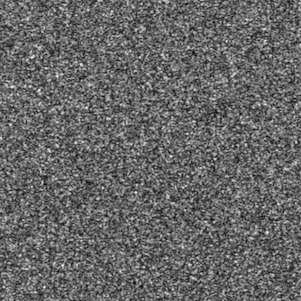

In [5]:
#println("ENL of region: ",round(SARProcessing.equivalent_number_of_looks_intensity(grd_image_hom.^2); digits = 2))
SARProcessing.sar2gray(grd_image_hom, p_quantile = 0.99999)

In [6]:
hom_descpek_mean_9 = SARProcessing.speckle_mean_filter(grd_image_hom.^2,[9,9]);

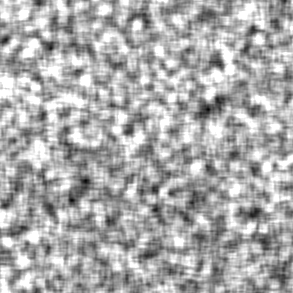

In [7]:
SARProcessing.sar2gray(hom_descpek_mean_9, p_quantile = 0.95)


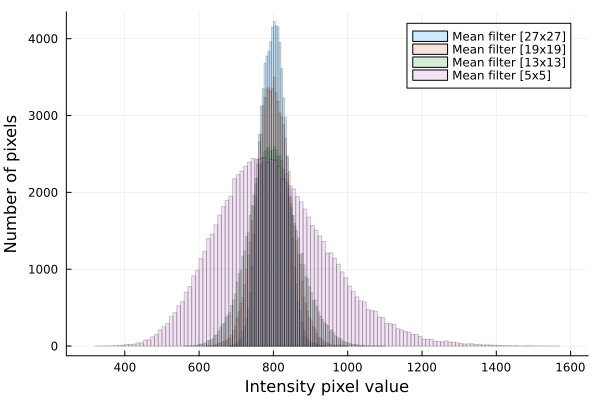

In [8]:
histogram(vcat(SARProcessing.speckle_mean_filter(grd_image_hom.^2,[27,27])...),label="Mean filter [27x27]", alpha = 0.2)
histogram!(vcat(SARProcessing.speckle_mean_filter(grd_image_hom.^2,[19,19])...),label="Mean filter [19x19]", alpha = 0.2)
histogram!(vcat(SARProcessing.speckle_mean_filter(grd_image_hom.^2,[13,13])...),label="Mean filter [13x13]", alpha = 0.2)
histogram!(vcat(SARProcessing.speckle_mean_filter(grd_image_hom.^2,[5,5])...),label="Mean filter [5x5]", alpha = 0.2)

xlabel!("Intensity pixel value")
ylabel!("Number of pixels")

We see that the Mean filter, and in fact many speckle filters, changes the distribution to a Gaussian distribution. With increasing filter sizes, we reduce the variance.

#### Inhomogenous region

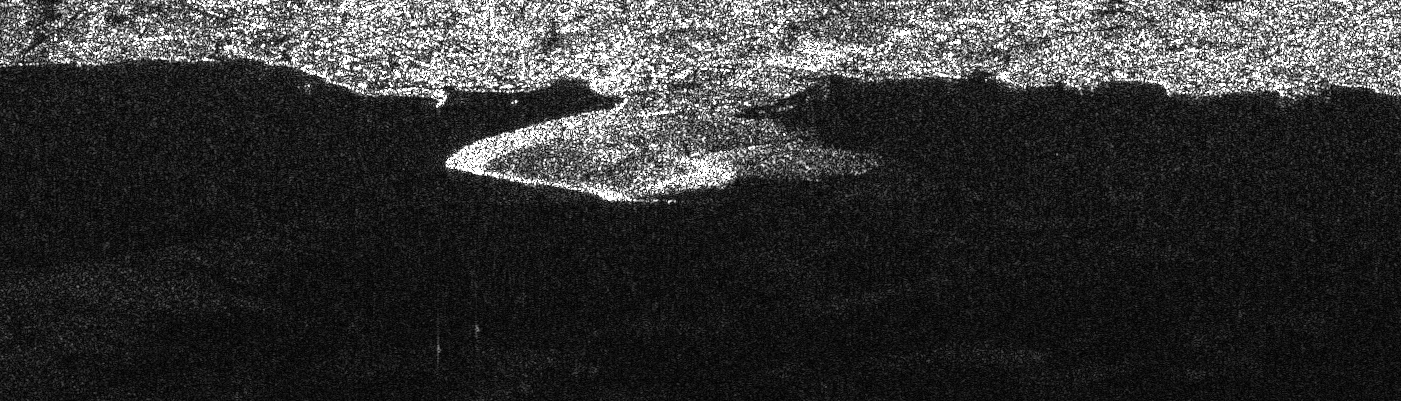

In [9]:
SARProcessing.sar2gray(slc_image[200:600,:], p_quantile = 0.96)

In [10]:
descpek_mean_9 = SARProcessing.speckle_mean_filter(slc_image,[11,11]);

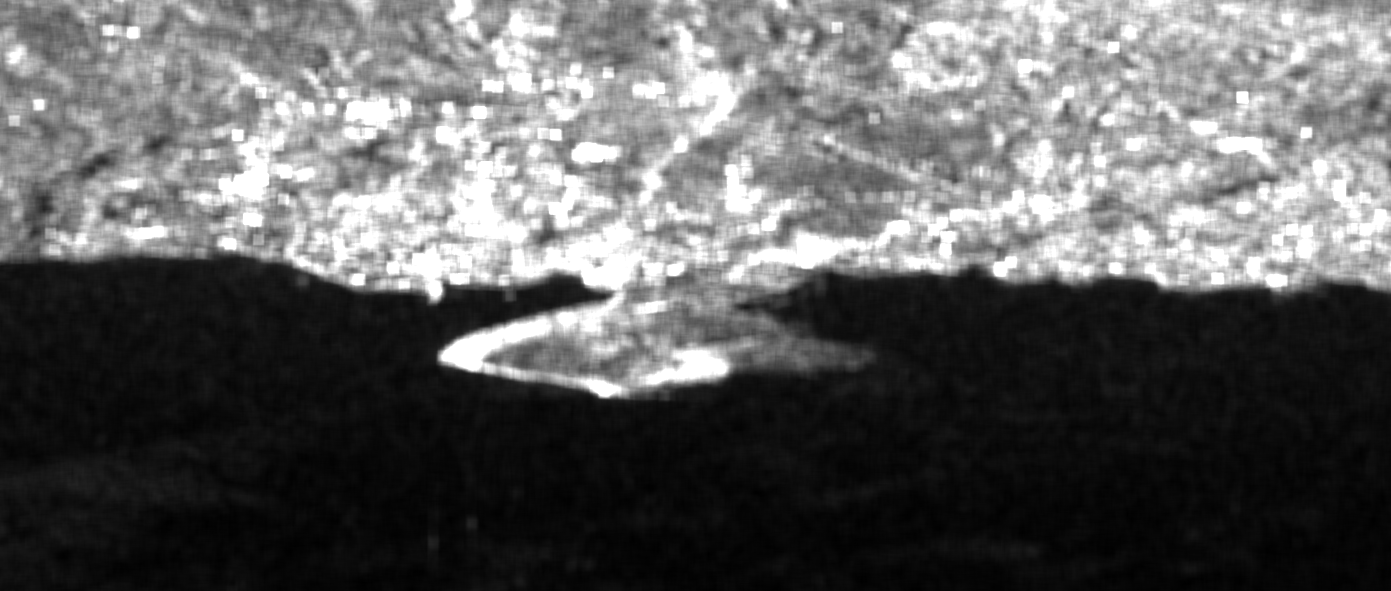

In [11]:
SARProcessing.sar2gray(descpek_mean_9, p_quantile = 0.95)

We see that the mean filter filters much of the noise in the ocean. However, we lose a lot of spatial content, e.g., near the shore or in the city.

**Question**: 
- Try to use the Lee filter to filter the image. 
- Are the results better? Why is that? 

(hint: Look at the SARProcessing.speckle_lee_filter function)